In [ ]:
#🔹 Step 0: Install Libraries

!pip install -q pandas numpy scikit-learn imbalanced-learn xgboost lightgbm catboost matplotlib seaborn joblib

In [ ]:
#🔹 Step 1: Imports & Setup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
import joblib

from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
RANDOM_STATE = 42

In [ ]:
#🔹 Step 2: Load Data

from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
    data_path = fn

df = pd.read_csv(data_path)
print("Shape:", df.shape)
df.head()


Saving employee_data.csv to employee_data.csv
Shape: (1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [ ]:
#🔹 Step 3: Basic Cleaning

# Example: Attrition is Yes/No
target_col = 'Attrition'
df[target_col] = df[target_col].map({'Yes':1, 'No':0})

# Drop constant/irrelevant columns
to_drop = ['EmployeeCount','EmployeeNumber','StandardHours','Over18']
df = df.drop(columns=[c for c in to_drop if c in df.columns])

print("Final shape:", df.shape)


Final shape: (1470, 31)


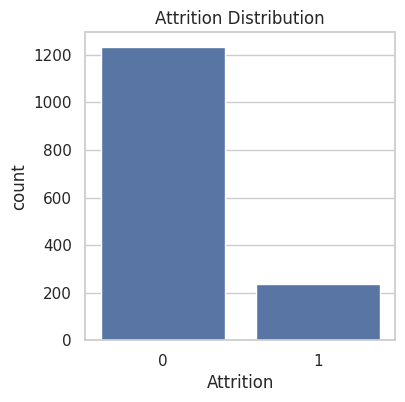

Attrition
0    83.877551
1    16.122449
Name: proportion, dtype: float64


In [ ]:
#🔹 Step 4: EDA + Visualizations

#Target Distribution
# Target balance
plt.figure(figsize=(4,4))
sns.countplot(x=target_col, data=df)
plt.title("Attrition Distribution")
plt.show()

print(df[target_col].value_counts(normalize=True)*100)


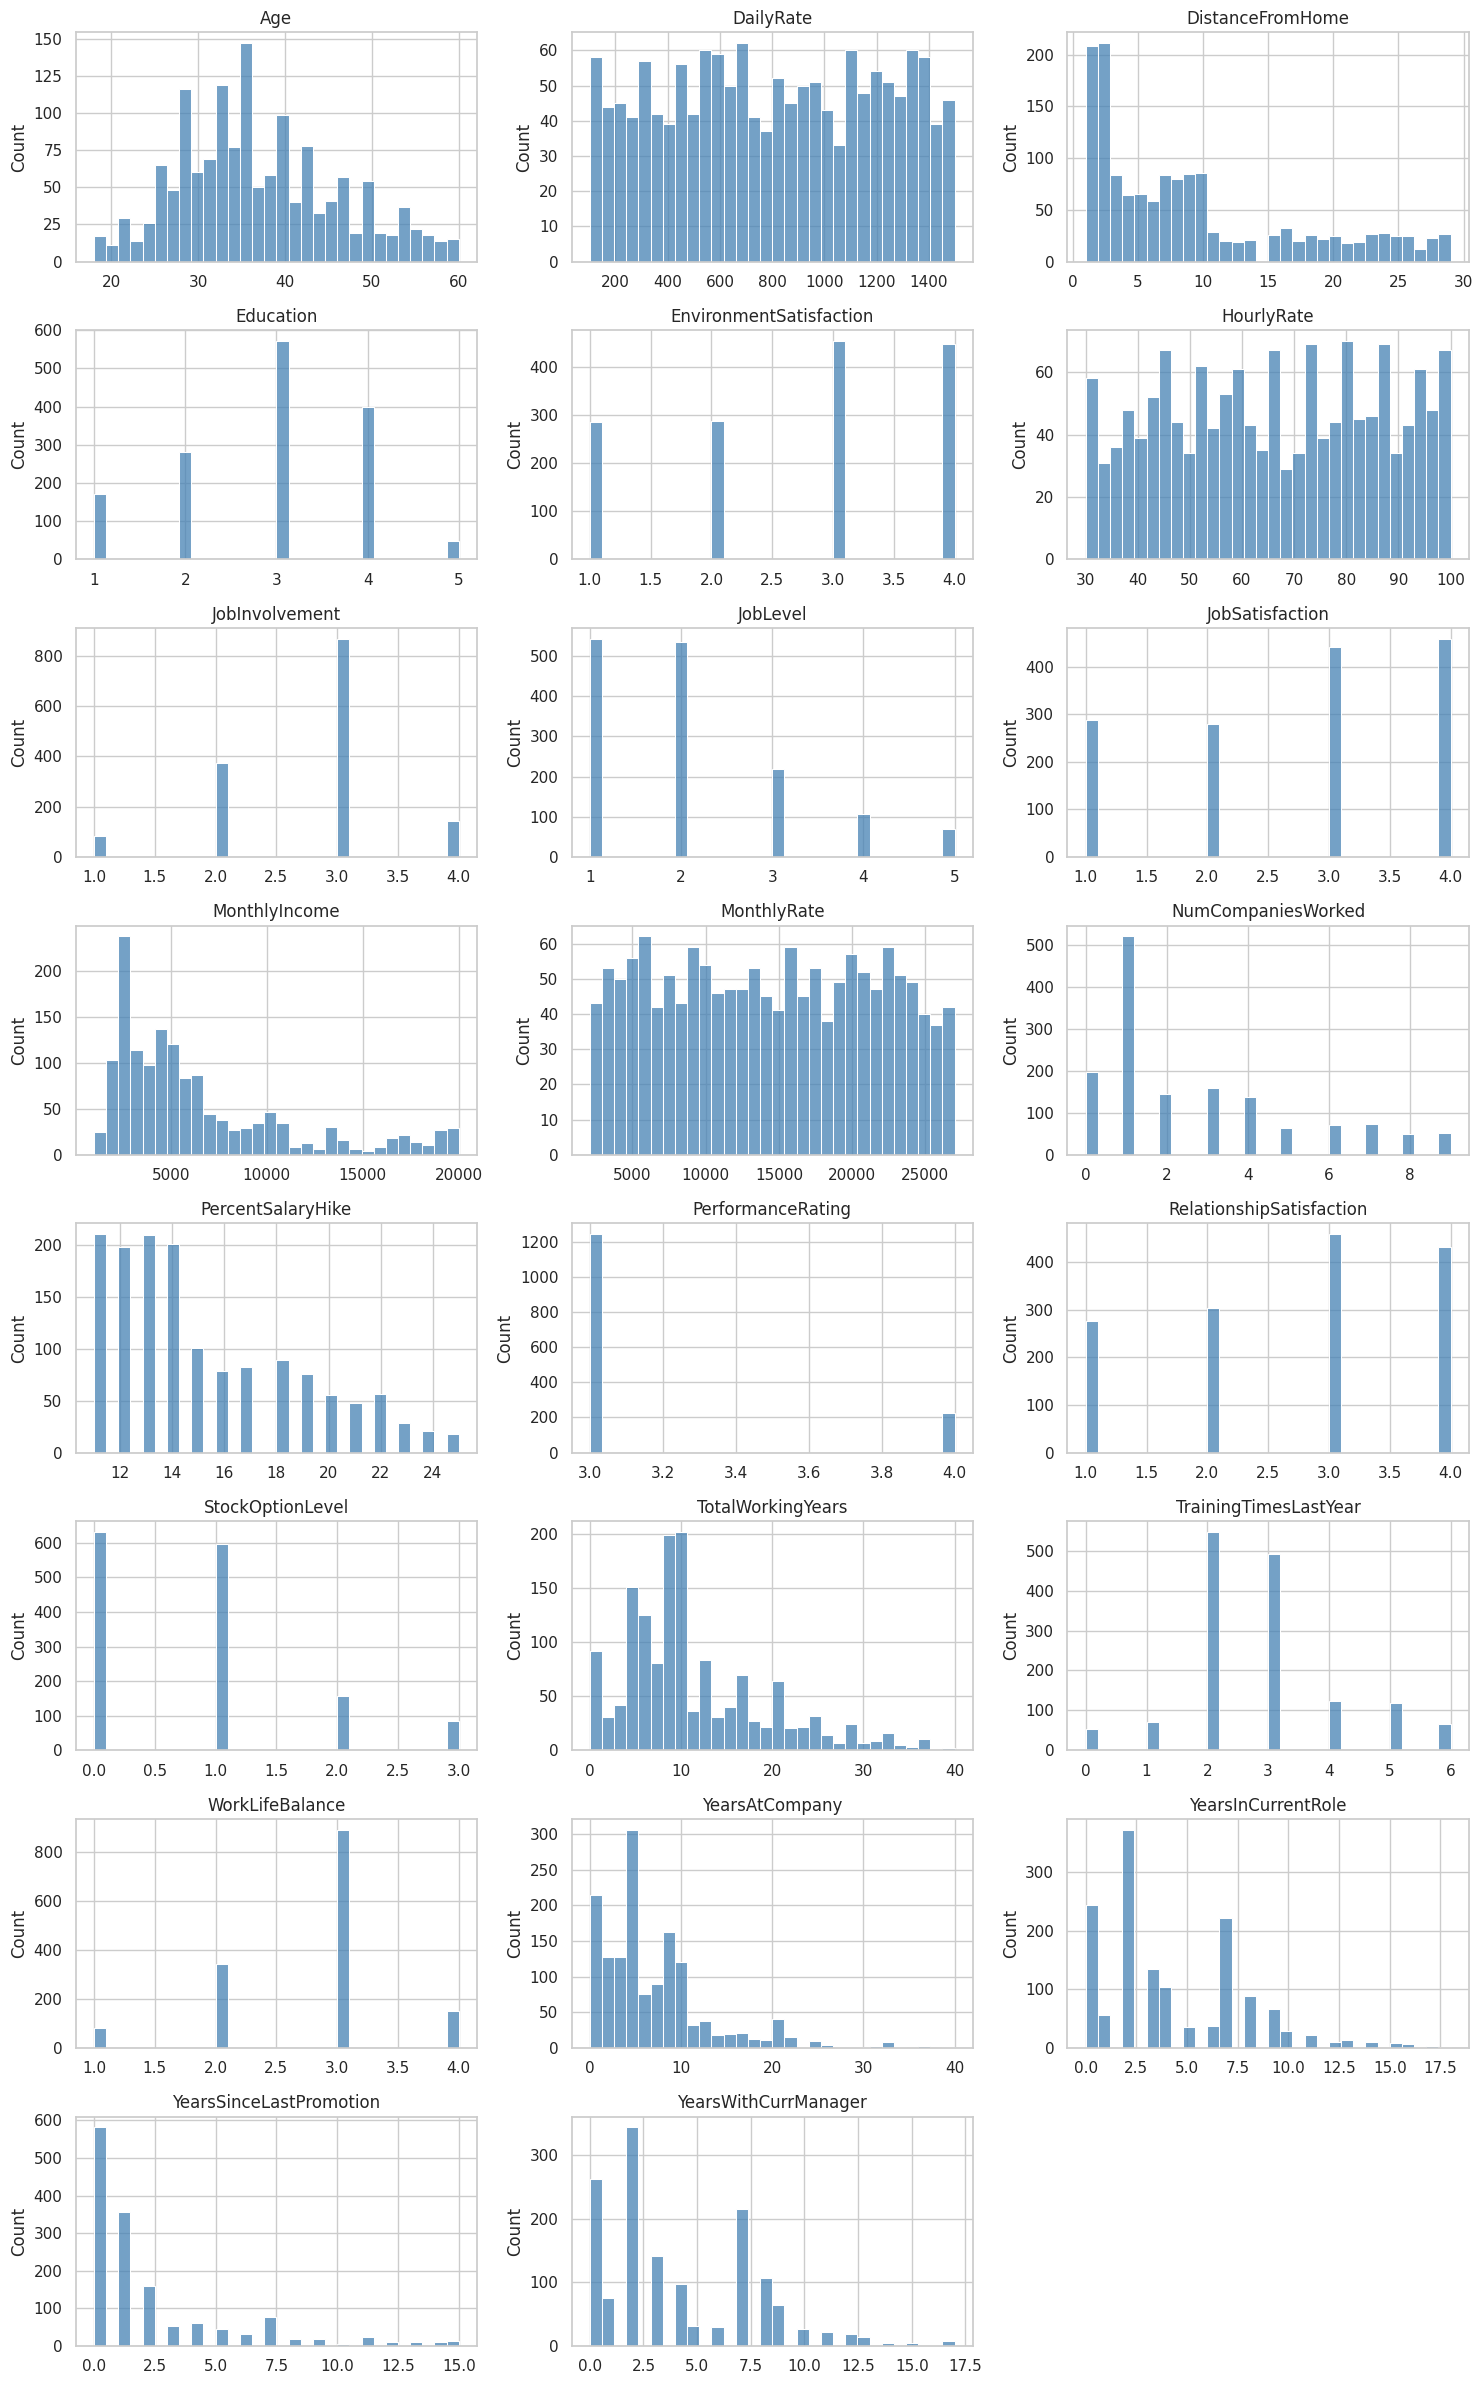

In [ ]:
# Numerical Feature Distributions

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'Attrition' in num_cols:  # drop target
    num_cols.remove('Attrition')

# Setup subplot grid
n_cols = 3  # how many plots per row
n_rows = int(np.ceil(len(num_cols)/n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows*3))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df[col], bins=30, kde=False, ax=axes[i], color="steelblue")
    axes[i].set_title(col, fontsize=12)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Count")

# Remove unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



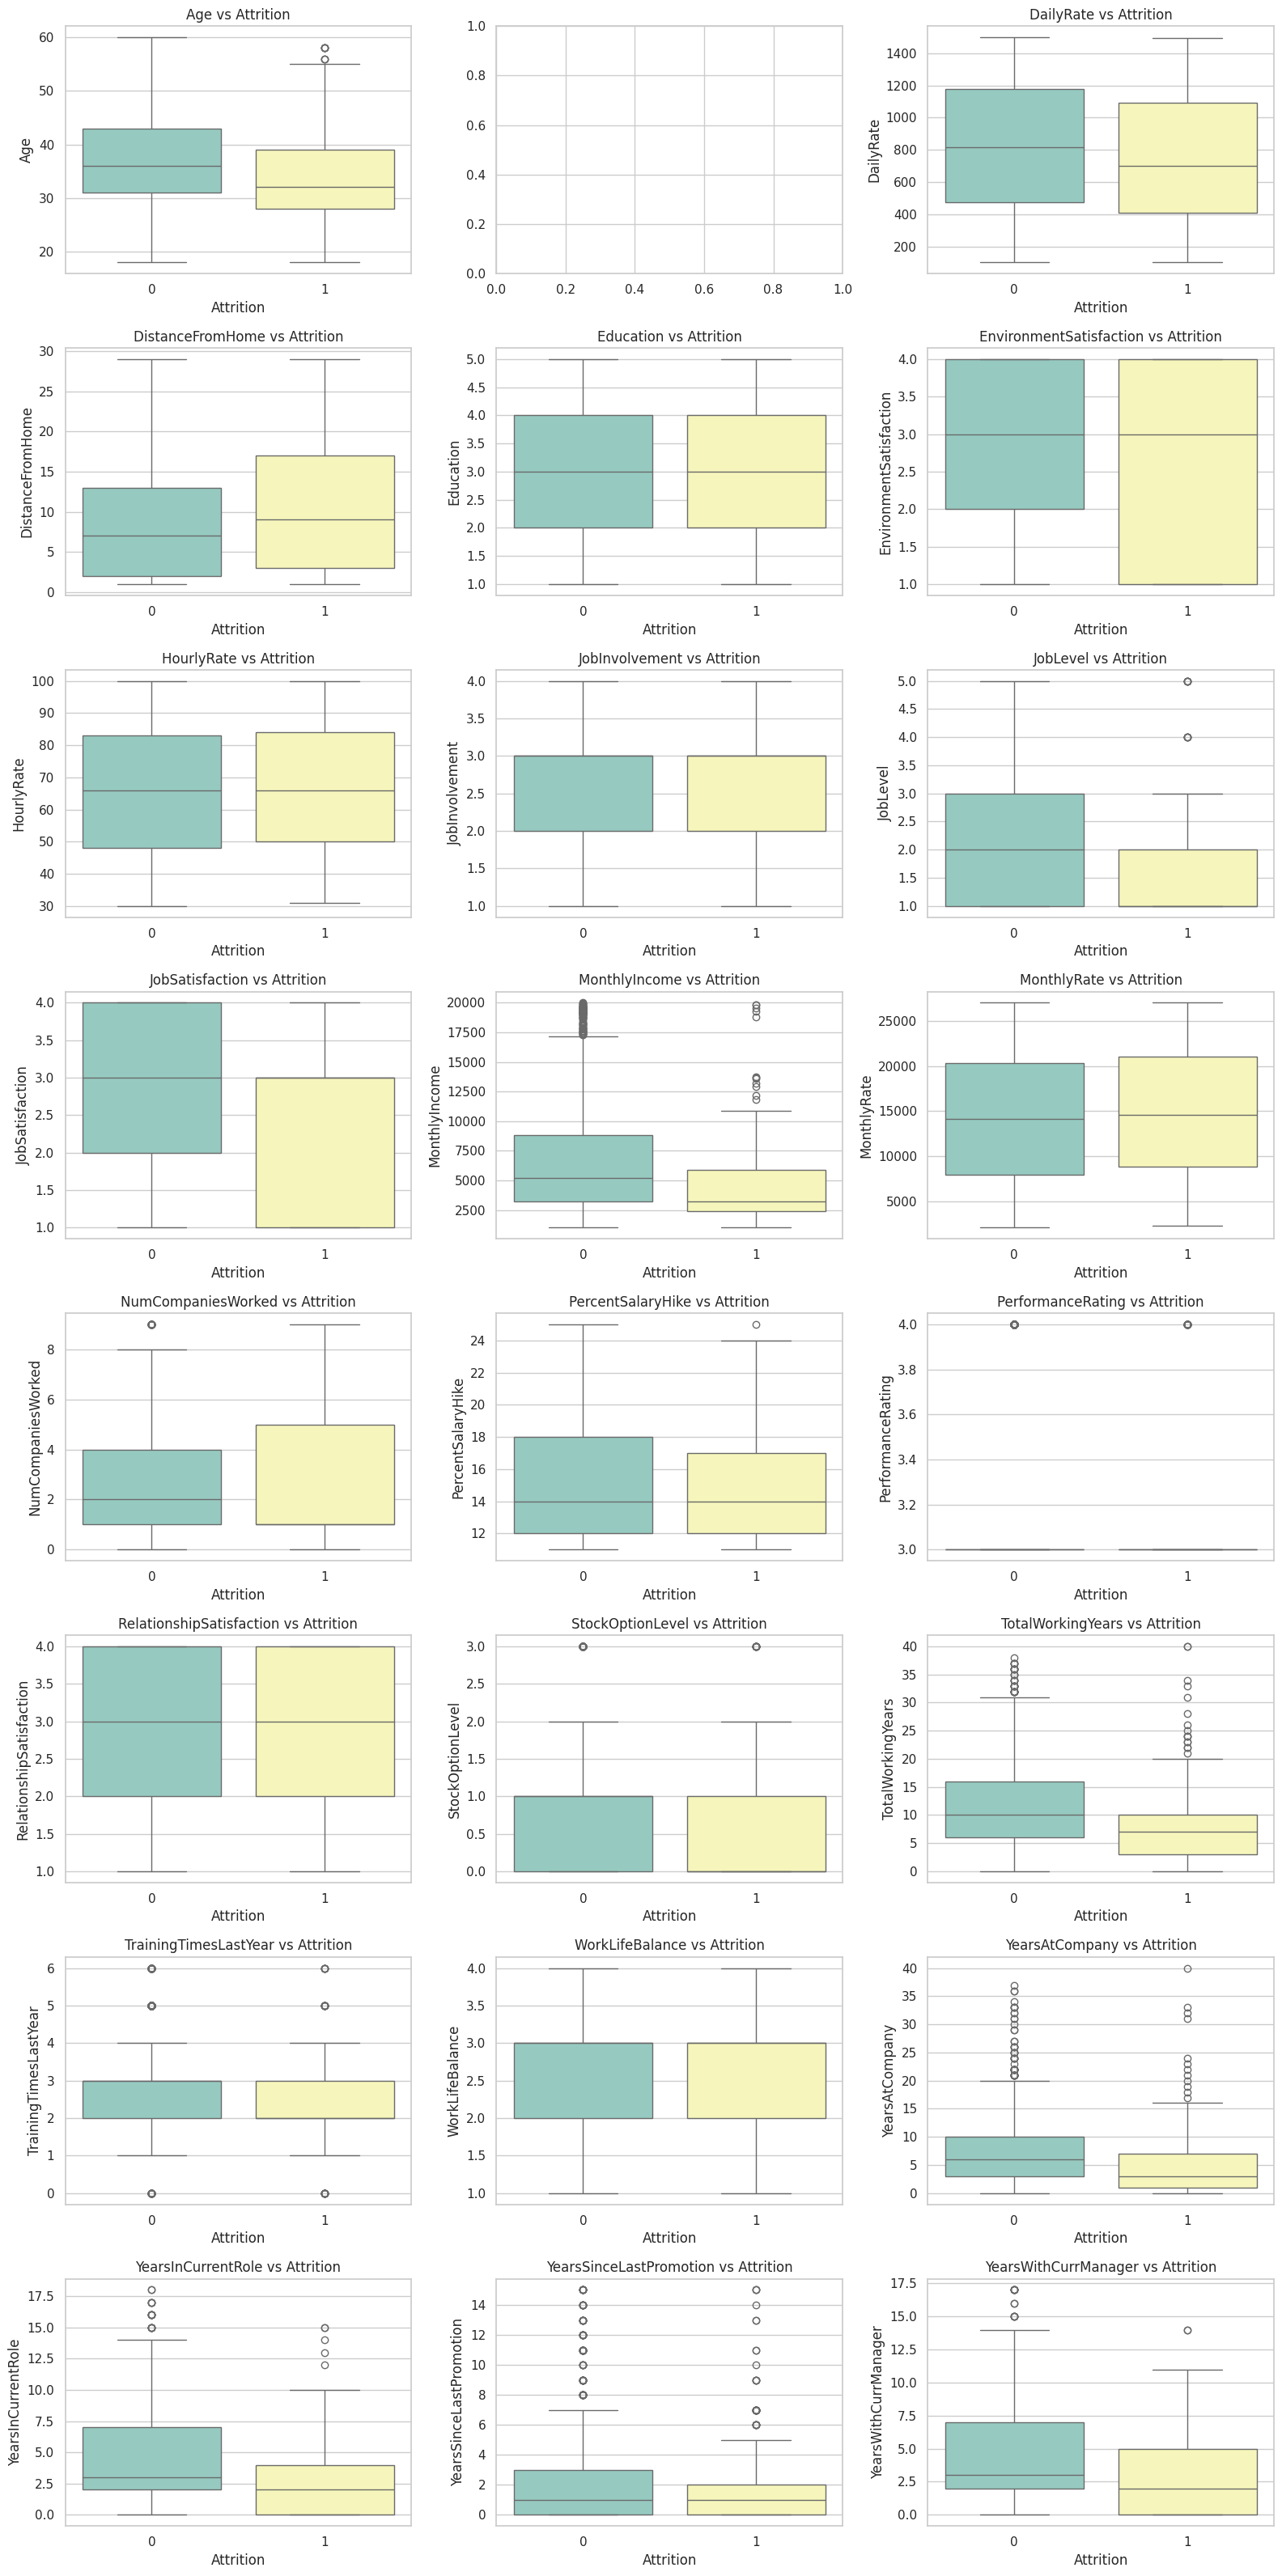

In [ ]:
# Boxplots of Numeric Features by Attrition

n_cols = 3
n_rows = int(np.ceil(len(num_cols)/n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows*4))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    if col != "Attrition":
        sns.boxplot(x="Attrition", y=col, data=df, ax=axes[i], palette="Set3")
        axes[i].set_title(f"{col} vs Attrition", fontsize=12)
        axes[i].set_xlabel("Attrition")
        axes[i].set_ylabel(col)

# Remove unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


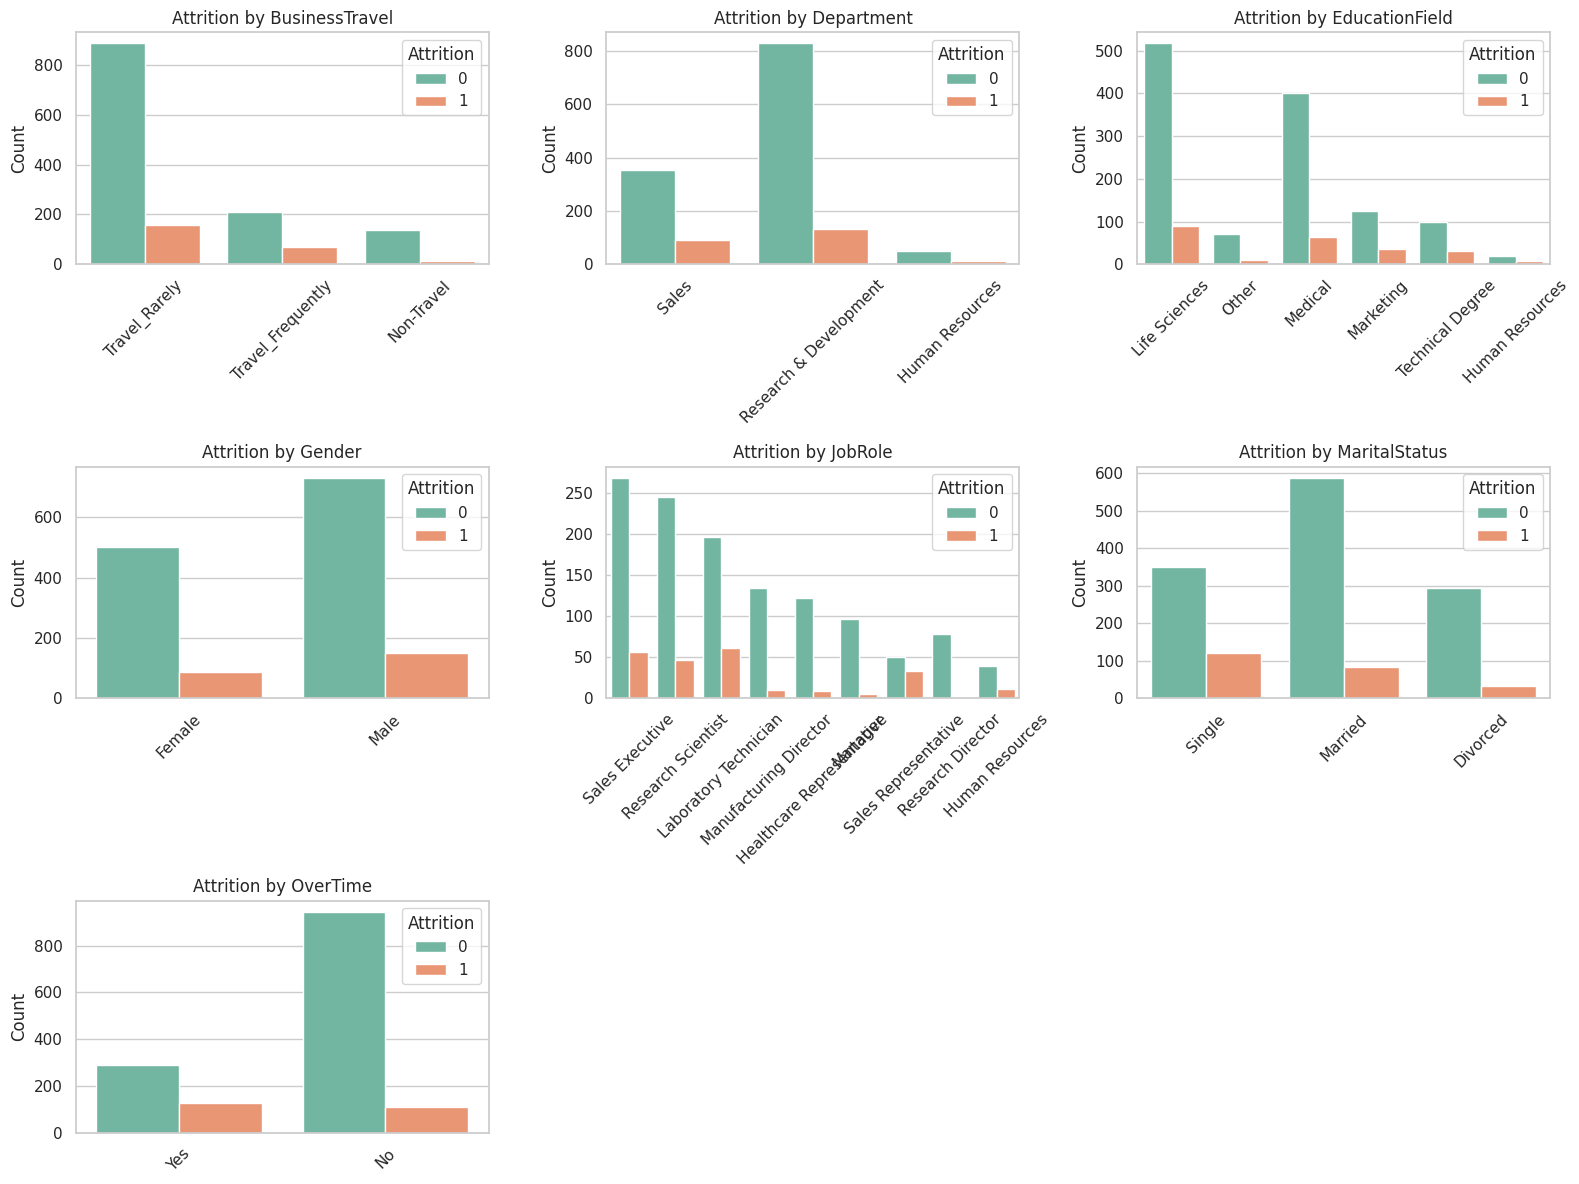

In [ ]:
#Categorical Features vs Attrition

cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()

n_cols = 3
n_rows = int(np.ceil(len(cat_cols)/n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows*4))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(data=df, x=col, hue="Attrition", ax=axes[i], palette="Set2")
    axes[i].set_title(f"Attrition by {col}", fontsize=12)
    axes[i].tick_params(axis="x", rotation=45)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Count")

# Remove unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


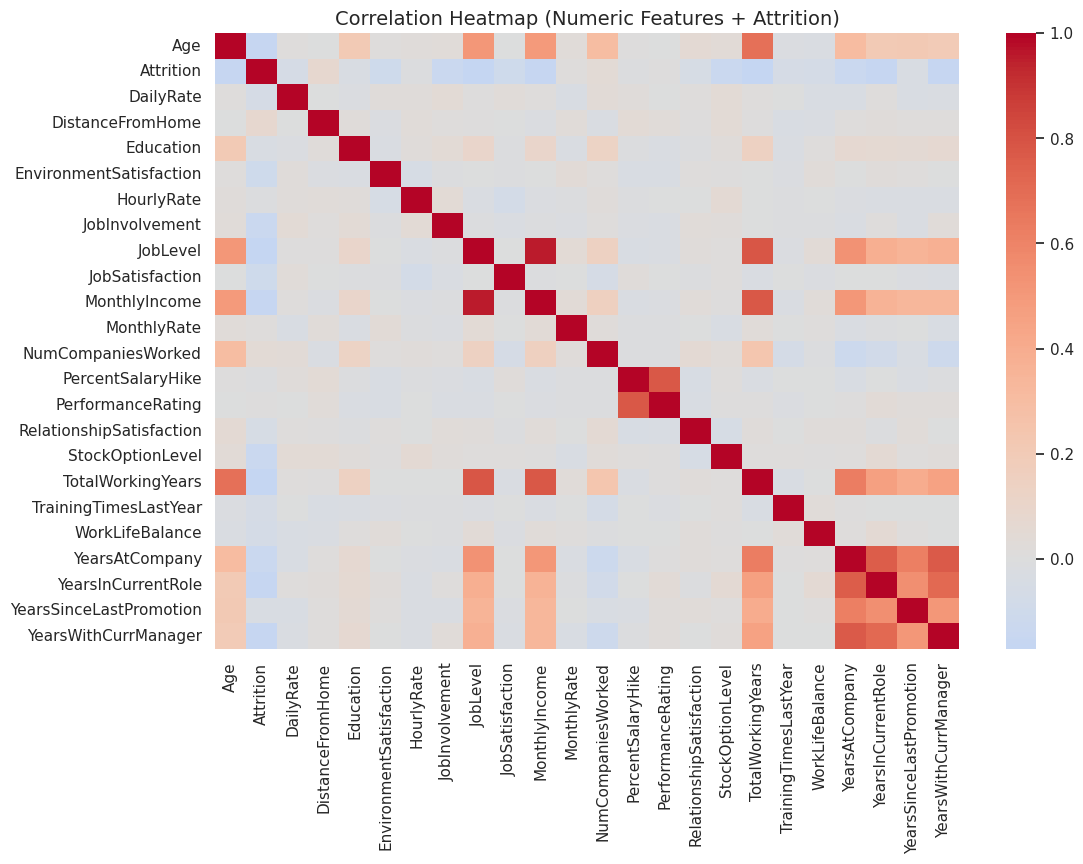

In [ ]:
# Correlation Heatmap

# Correlation only for numeric features + target
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

plt.figure(figsize=(12,8))
corr = df[num_cols].corr()

sns.heatmap(corr, cmap="coolwarm", center=0, annot=False, cbar=True)
plt.title("Correlation Heatmap (Numeric Features + Attrition)", fontsize=14)
plt.show()


In [ ]:
# Separate features and target
X = df.drop(columns=["Attrition"])
y = df["Attrition"]

# Define numeric & categorical features from X only
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

# Pipelines
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# Column transformer
preprocessor = ColumnTransformer([
    ("num", num_pipe, numeric_cols),
    ("cat", cat_pipe, categorical_cols)
])


Numeric columns: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
Categorical columns: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']


In [ ]:
# 📌 Step 5: Train/Validation/Test Split

X = df.drop(columns=["Attrition"])
y = df["Attrition"]

# Train + Temp (Val+Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Temp -> Val + Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# Transform data
preprocessor.fit(X_train)
X_train_enc = preprocessor.transform(X_train)
X_val_enc = preprocessor.transform(X_val)
X_test_enc = preprocessor.transform(X_test)


Train: (1029, 30) Val: (220, 30) Test: (221, 30)


In [ ]:
# 📌 Step 6: Define Models

# Class imbalance ratio for boosting
n_neg, n_pos = (y_train==0).sum(), (y_train==1).sum()
scale_pos_weight = n_neg / n_pos if n_pos>0 else 1.0

models_classweight = {
    "LogisticRegression_bal": LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42),
    "DecisionTree_bal": DecisionTreeClassifier(class_weight="balanced", random_state=42),
    "RandomForest_bal": RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42),
    "XGBoost_bal": xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss",
                                     scale_pos_weight=scale_pos_weight, n_estimators=200, random_state=42),
    "LightGBM_bal": lgb.LGBMClassifier(class_weight="balanced", n_estimators=200, random_state=42),
    "CatBoost_bal": CatBoostClassifier(iterations=200, verbose=0, random_seed=42,
                                       class_weights=[float(n_neg), float(n_pos)])
}

In [ ]:
# 📌 Step 7: Evaluation Function

def evaluate_model(name, model, X_train, y_train, X_val, y_val, X_test, y_test):
    model.fit(X_train, y_train)

    def metrics(X, y, label):
        y_pred = model.predict(X)
        y_proba = model.predict_proba(X)[:,1] if hasattr(model,"predict_proba") else model.decision_function(X)
        return {
            "model": name,
            "dataset": label,
            "accuracy": accuracy_score(y, y_pred),
            "precision": precision_score(y, y_pred, zero_division=0),
            "recall": recall_score(y, y_pred, zero_division=0),
            "f1": f1_score(y, y_pred, zero_division=0),
            "roc_auc": roc_auc_score(y, y_proba)
        }

    results = []
    results.append(metrics(X_train, y_train, "Train"))
    results.append(metrics(X_val, y_val, "Validation"))
    results.append(metrics(X_test, y_test, "Test"))

    return pd.DataFrame(results)

In [ ]:
# 📌 Step 8: Train Class Weight Models

results_classweight = []
for name, model in models_classweight.items():
    print("Training:", name)
    df_res = evaluate_model(name, model, X_train_enc, y_train, X_val_enc, y_val, X_test_enc, y_test)
    results_classweight.append(df_res)

results_classweight = pd.concat(results_classweight).reset_index(drop=True)


Training: LogisticRegression_bal
Training: DecisionTree_bal
Training: RandomForest_bal
Training: XGBoost_bal
Training: LightGBM_bal
[LightGBM] [Info] Number of positive: 166, number of negative: 863
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1166
[LightGBM] [Info] Number of data points in the train set: 1029, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training: CatBoost_bal


In [ ]:
# 📌 Step 9: Train SMOTE Models

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train_enc, y_train)

models_smote = {
    "LogisticRegression_SMOTE": LogisticRegression(max_iter=2000, random_state=42),
    "DecisionTree_SMOTE": DecisionTreeClassifier(random_state=42),
    "RandomForest_SMOTE": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost_SMOTE": xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss",
                                       n_estimators=200, random_state=42),
    "LightGBM_SMOTE": lgb.LGBMClassifier(n_estimators=200, random_state=42),
    "CatBoost_SMOTE": CatBoostClassifier(iterations=200, verbose=0, random_seed=42)
}

results_smote = []
for name, model in models_smote.items():
    print("Training:", name)
    df_res = evaluate_model(name, model, X_train_sm, y_train_sm, X_val_enc, y_val, X_test_enc, y_test)
    results_smote.append(df_res)

results_smote = pd.concat(results_smote).reset_index(drop=True)


Training: LogisticRegression_SMOTE
Training: DecisionTree_SMOTE
Training: RandomForest_SMOTE
Training: XGBoost_SMOTE
Training: LightGBM_SMOTE
[LightGBM] [Info] Number of positive: 863, number of negative: 863
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6889
[LightGBM] [Info] Number of data points in the train set: 1726, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training: CatBoost_SMOTE


In [ ]:
# 📌 Step 10: Combine Results

all_results = pd.concat([results_classweight, results_smote]).reset_index(drop=True)

# Sort by Validation ROC-AUC, then F1
summary = (all_results
           .query("dataset=='Validation'")
           .sort_values(by=["roc_auc","f1"], ascending=False)
           .reset_index(drop=True))

print("📊 Validation Results (sorted by ROC-AUC, F1)")
display(summary)

all_results.to_csv("all_model_results.csv", index=False)
print("Saved all results to all_model_results.csv")


📊 Validation Results (sorted by ROC-AUC, F1)


,model,dataset,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression_bal,Validation,0.795455,0.410714,0.657143,0.505495,0.803552
1,LogisticRegression_SMOTE,Validation,0.800000,0.411765,0.600000,0.488372,0.791042
2,CatBoost_SMOTE,Validation,0.859091,0.666667,0.228571,0.340426,0.774981
3,CatBoost_bal,Validation,0.840909,0.000000,0.000000,0.000000,0.773900
4,RandomForest_SMOTE,Validation,0.854545,0.636364,0.200000,0.304348,0.739151
5,RandomForest_bal,Validation,0.836364,0.400000,0.057143,0.100000,0.733282
6,XGBoost_SMOTE,Validation,0.854545,0.636364,0.200000,0.304348,0.712896
7,LightGBM_bal,Validation,0.831818,0.437500,0.200000,0.274510,0.711969
8,LightGBM_SMOTE,Validation,0.854545,0.636364,0.200000,0.304348,0.710888
9,XGBoost_bal,Validation,0.831818,0.437500,0.200000,0.274510,0.695907


Saved all results to all_model_results.csv


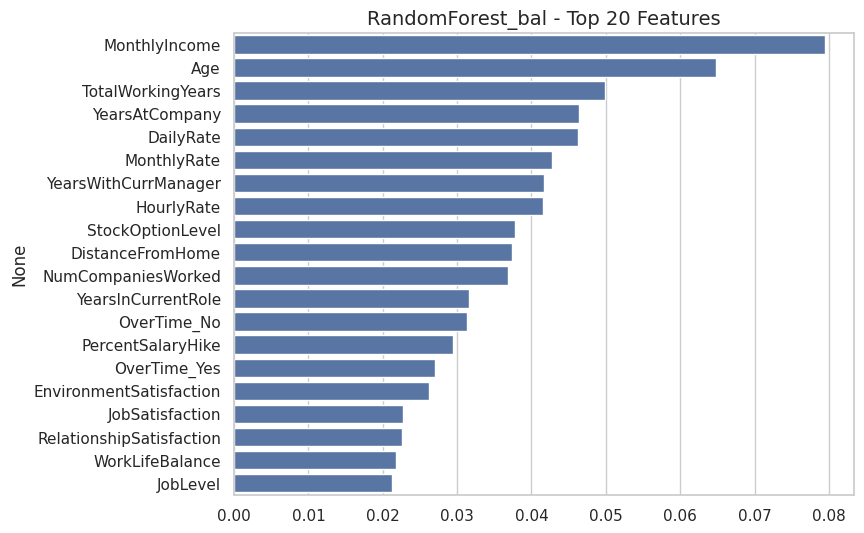

In [ ]:
# 📌 Step 11: Feature Importance (Tree Models)

def plot_feature_importance(model, model_name, feature_names, top_n=20):
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    elif hasattr(model, "get_feature_importance"):  # CatBoost
        importances = model.get_feature_importance()
    else:
        print("No feature importance available for", model_name)
        return

    fi = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(top_n)
    plt.figure(figsize=(8,6))
    sns.barplot(x=fi.values, y=fi.index)
    plt.title(f"{model_name} - Top {top_n} Features", fontsize=14)
    plt.show()

# Get feature names after preprocessing
ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
cat_features = list(ohe.get_feature_names_out(categorical_cols))
feature_names = numeric_cols + cat_features

# Example: show from Random Forest (balanced)
rf_model = models_classweight["RandomForest_bal"]
rf_model.fit(X_train_enc, y_train)
plot_feature_importance(rf_model, "RandomForest_bal", feature_names)


In [ ]:
# Merge Train + Validation

X_trainval = np.vstack([X_train_enc, X_val_enc])
y_trainval = np.concatenate([y_train, y_val])

print("Train+Val:", X_trainval.shape, " Test:", X_test_enc.shape)


Train+Val: (1249, 51)  Test: (221, 51)


In [ ]:
# Define Search Spaces

# Logistic Regression
log_reg = LogisticRegression(max_iter=3000, class_weight="balanced", random_state=42)

param_grid_lr = {
    "C": np.logspace(-3, 3, 10),   # regularization strength
    "solver": ["liblinear", "saga"]
}


In [ ]:
# Random Forest

rf = RandomForestClassifier(class_weight="balanced", random_state=42)

param_grid_rf = {
    "n_estimators": [100, 200, 500],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}


In [ ]:
# CatBoost

from catboost import CatBoostClassifier

cat = CatBoostClassifier(verbose=0, random_seed=42, class_weights=[(y_train==0).sum(), (y_train==1).sum()])

param_grid_cat = {
    "depth": [4, 6, 8, 10],
    "learning_rate": [0.01, 0.05, 0.1],
    "iterations": [200, 500, 800]
}


In [ ]:
# Run RandomizedSearchCV

scorer = make_scorer(roc_auc_score, needs_proba=True)

# Logistic Regression tuning
rs_lr = RandomizedSearchCV(log_reg, param_distributions=param_grid_lr,
                           n_iter=10, scoring=scorer, cv=5, random_state=42, n_jobs=-1, verbose=1)
rs_lr.fit(X_trainval, y_trainval)
print("Best Logistic Regression params:", rs_lr.best_params_)

# Random Forest tuning
rs_rf = RandomizedSearchCV(rf, param_distributions=param_grid_rf,
                           n_iter=20, scoring=scorer, cv=5, random_state=42, n_jobs=-1, verbose=1)
rs_rf.fit(X_trainval, y_trainval)
print("Best Random Forest params:", rs_rf.best_params_)

# Optional CatBoost tuning
rs_cat = RandomizedSearchCV(cat, param_distributions=param_grid_cat,
                            n_iter=10, scoring=scorer, cv=3, random_state=42, n_jobs=-1, verbose=1)
rs_cat.fit(X_trainval, y_trainval)
print("Best CatBoost params:", rs_cat.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Logistic Regression params: {'solver': 'liblinear', 'C': np.float64(0.001)}
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Random Forest params: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 10}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best CatBoost params: {'learning_rate': 0.1, 'iterations': 800, 'depth': 10}


In [ ]:
# Evaluate on Test

best_lr = rs_lr.best_estimator_
best_rf = rs_rf.best_estimator_
best_cat = rs_cat.best_estimator_

def evaluate_final(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    print(f"\n=== {name} on Test Set ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, zero_division=0))
    print("Recall:", recall_score(y_test, y_pred, zero_division=0))
    print("F1:", f1_score(y_test, y_pred, zero_division=0))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))

evaluate_final("Logistic Regression", best_lr, X_test_enc, y_test)
evaluate_final("Random Forest", best_rf, X_test_enc, y_test)
evaluate_final("CatBoost", best_cat, X_test_enc, y_test)



=== Logistic Regression on Test Set ===
Accuracy: 0.6470588235294118
Precision: 0.2857142857142857
Recall: 0.7777777777777778
F1: 0.417910447761194
ROC-AUC: 0.7915915915915915

=== Random Forest on Test Set ===
Accuracy: 0.8416289592760181
Precision: 0.5217391304347826
Recall: 0.3333333333333333
F1: 0.4067796610169492
ROC-AUC: 0.8624624624624624

=== CatBoost on Test Set ===
Accuracy: 0.8733031674208145
Precision: 1.0
Recall: 0.2222222222222222
F1: 0.36363636363636365
ROC-AUC: 0.842042042042042
